Bayesian System Identification of a Harmonic Oscillator using Probabilistic Programming
===========================

In this problem we will use probabilistic programming to infer the mass, spring constant, damping, and initial velocity of a Mass-Spring-Damper system, given only noisy measurements of that system.

For this, we can use any probabilistic programming library that you like (e.g., PyMC3, Tensorflow Probability, Pyro, Edward, Turing, etc.).

In [2]:
# If using PyMC3 you may want to make sure PyMC3 and arviz is installed
# Uncomment below, if so, otherwise 
!pip install arviz
# or, if you need pymc3 as well:
!pip install pymc3[plots]
# Alternatively, you can run this in a colab instance, like shown in class

  Stored in directory: C:\Users\Himanshu Singhal\AppData\Local\pip\Cache\wheels\88\fb\be\483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built theano


In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import pandas as pd
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
D:\Anaconda\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Model Definition: Damped Harmonic Oscillator
From Dynamics class, we can recall that the solution to an unforced damped harmonic oscillator (like a Mass-Spring-Damper System with no external forces on it) is:
$$
\hat{y}(t) = A\exp(\frac{-c t}{2m})\sin(\omega t+\phi)
$$
where
$$
\begin{eqnarray}
  \omega &=& \frac{\sqrt{4mk-c^2}}{2m}\\
  B &=& \frac{v_0+y_0 \cdot \frac{c}{2m}}{\omega} \\
  \phi &=& \tan^{-1}\left(\frac{y_0}{B}\right)\\
  A &=& \sqrt{y_0^2 +  B^2}
\end{eqnarray}
$$
and $m$, $c$, $k$, $y_0$, and $v_0$ are the mass, damping coefficient, spring constant, initial position, and initial velocity, respectively.

However, in this problem we will assume that we are only given position measurement data, which is slightly noisy, and that we want to infer (using probabilistic programming) the possible values for the mass, spring constant, damping coefficient, and initial velocity, given that we know the system started from $y_0=1$.

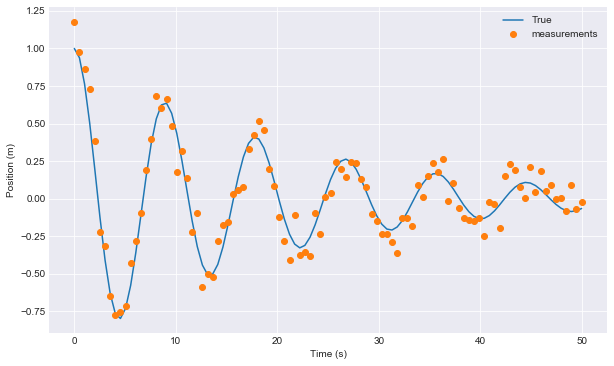

In [4]:
# Code to generate the noisy measurements
# Number of Timesteps
T = 100
np.random.seed(0)

# Textbook solution to Unforced Mass-Spring-Damper Harmonic Oscillator
def MSD(t,m,k,c,y0,v0):
  omega = np.sqrt(4*m*k-c**2)/(2*m)
  B = (v0+y0*c/(2*m))/omega 
  phi = np.arctan(y0/B)
  A = np.sqrt(y0**2 +  B**2)
  y = A*np.exp(-c*t/(2*m))*np.sin(omega*t+phi)
  return y

# Simulate the true system:
time_vec = np.linspace(0, 50, T)
ytrue = MSD(time_vec, 
            m=10, 
            k=5,
            c=1,
            y0=1,
            v0=0)

# Add Measurement Noise
measurements = ytrue + 0.1*np.random.randn(T)

plt.figure(figsize=(10, 6))
plt.plot(time_vec, ytrue, label='True')
plt.plot(time_vec, measurements,'o', label='measurements')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()


# Task1: Build the Probabilistic Model

Using the probabilistic programming language of your choice, build a probabilistic model of the position as a function of time, with the following prior beliefs about the other system parameters:
$$
P(\mathbf{y},m,k,c,v_0|T) = \sum_{t \in T} {\cal N}(y_t | \hat{y}(t,m,k,c,v_0),\sigma^2)P(m)P(c)P(k)P(v_0)P(sigma)
$$
where
$$
\begin{eqnarray}
  P(m)&\sim & {\cal N}(\mu_m=10, \sigma_m = 0.01) \\
  P(k)&\sim & {\cal N}(\mu_k=10, \sigma_k = 5)  \\
  P(c)&\sim & {\cal N}(\mu_c=5, \sigma_c = 2)  \\
  P(v_0)&\sim & {\cal N}(\mu_{v_0}=0, \sigma_{v_0} = 5)  \\
  P(sigma )&\sim & \mathrm{Gamma}(\alpha = 0.2, \beta = 1) \\
\end{eqnarray}
$$

While this seems like perhaps a complicated model, using probabilistic programming this basically means:

1. Instantiate probabilistic variables `m`,`c`,`k`, `v0` and `sigma` with the appropriate Normal and Gamma prior distributions.
2. Use them when computing the dynamics solution above.
3. Set the output variable `y` to be the observed variable using `measurements` as the observations.
4. Sample the model with N=15K samples. (e.g., I would suggest the NUTS sampler with 15K samples and using around 2000 tuning samples). Use at least two chains for comparison sake later.

Hint: If you have issues getting your sampling chains to converge, you can try: (1) increasing the number of samples, (2) increasing the number of tuning samples you allow `tuning = ####`, or (3) increasing the target acceptance rate for the MCMC samples (`target_accept=0.95` or `.99`, etc.). You can also increase the number of independent chains via `chains=3` or `4` or other numbers, though I would try increasing the number of samples first.

Hint 2: You will notice that our prior belief about the mass is really tight ($\sigma_m=0.01$). This is on purpose and not a typo. Task 3 will explore what happens if this is not the case. In more realistic problems, we may not know the mass with such accuracy, though for this task we will assume that we do.


In [5]:
# Instantiate probabilistic variable
with pm.Model() as full_model:
  m_new = pm.Normal('m_new', mu=10 , sd=0.01)
  k_new = pm.Normal('k_new', mu=10 , sd=5)
  c_new = pm.Normal('c_new', mu=5 , sd=2)
  v0_new = pm.Normal('v0_new', mu=0 , sd=5)
  sigma_new = pm.Gamma('sigma_new', alpha=0.2 , beta=1 )
  y0 = 1

  # ynew = MSD(time_vec, m_new, k_new, c_new, y0, v0_new)

  # Probabilistic Model
  Y_prb = pm.Normal('Y_prb', mu = ytrue , sd = sigma_new**2 , observed = measurements)
  Y_prb = pm.Normal('Y_prb', mu = ynew , sd = sigma_new**2 , observed = measurements)
#   Y_prb = sum([pm.Normal('Y_prb', mu = ytrue , sd = sigma_new**2 , observed = measurements)*m_new*k_new*c_new*v0_new*sigma_new],T )
  measurements_new = Y_prb + 0.1*np.random.randn(T)

In [0]:
# Using MAP to estimate the parameters for the given model
# from pymc3 import find_MAP
# # from scipy import optimize

# map_estimate = find_MAP(model=full_model, method = 'powell')
# # map_estimate = find_MAP(model=full_model)
# print(map_estimate)

In [6]:
# Sampling Code Here
# Sampling Code
with full_model:
    trace = pm.sample(15000 , tune = 2000 , chains = 3 , target_accept = 0.99, progressbar = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [sigma_new, v0_new, c_new, k_new, m_new]
100%|██████████| 17000/17000 [00:30<00:00, 550.55it/s]


# Task 2: Inspect the model

Now that you have your samples, go ahead and inspect the output of the probabilistic program. Specifically:

## Plot the trace plots of the uncertain parameters.




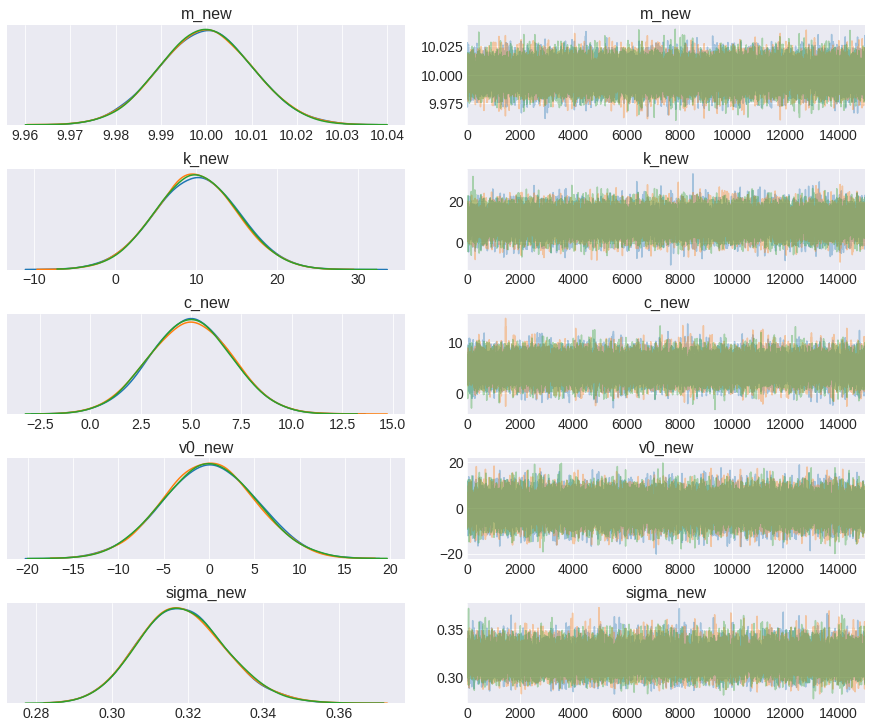

In [7]:
# Your Code here
_ = pm.traceplot(trace)

In [8]:
pm.gelman_rubin(trace)

{'c_new': 1.0000224729518135,
 'k_new': 1.0000348068250555,
 'm_new': 0.9999679458632472,
 'sigma_new': 0.9999774351079379,
 'v0_new': 1.0000280439167863}


## Provide the Summary statistics of the uncertain parameters
That is, compute the mean, and 95% posterior interval for the main system parameters (mass, spring constant, damping).

In [9]:
# Your code here
# Summary Statistics of the unknown parameters
# pm.summary(trace)
# Mean and 95% posterior interval of the unknown parameters
def trace_quantiles_UB(x):
   return pd.DataFrame(pm.quantiles(x, [95]))

def trace_quantiles_LB(x):
   return pd.DataFrame(pm.quantiles(x, [-95]))

  
def trace_mean(x):
  return pd.Series(np.mean(x,0) , name = 'mean')

print(pm.summary(trace, ['m_new'], stat_funcs=[trace_mean,trace_quantiles_UB, trace_quantiles_LB]))
print(pm.summary(trace, ['k_new'], stat_funcs=[trace_mean,trace_quantiles_UB, trace_quantiles_LB]))
print(pm.summary(trace, ['c_new'], stat_funcs=[trace_mean,trace_quantiles_UB,trace_quantiles_LB]))

           mean         95       -95
m_new  10.00001  10.016556  9.983615
           mean         95       -95
k_new  9.989155  18.276985  1.741958
           mean        95       -95
c_new  4.982516  8.270168  1.688414


## Plot the 95% CI bound on the predicted true function
Using the samples you gathered while running your probabilistic program, produce a plot that compares (with time on the x-axis):

1. The provided measurements (`measurements`)
2. The true function (`ytrue`)
3. The mean predicted function (from your model)
4. The 95% CI upper bound on the function over time (from your model)
5. The 95% CI lower bound on the function over time (from your model).

Ideally, your 95% CI should contain the true function, if your probabilistic program is well-calibrated (i.e., has an appropriate measure of its own uncertainty).

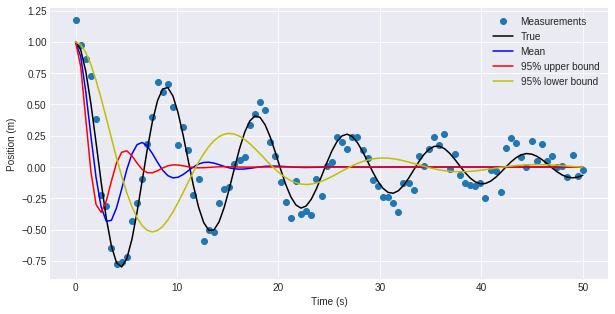

In [21]:
# Your Code Here
ymean = MSD(time_vec, m=9.99, k=10.01, c=5.004, y0=1, v0=0)

y95_ub = MSD(time_vec, m=10.01, k=18.26, c=8.27, y0=1, v0=0)

y95_lb = MSD(time_vec, m=9.98, k=1.79, c=1.73, y0=1, v0=0)

plt.figure(figsize=(10, 5))
plt.plot(time_vec, measurements,'o', label='Measurements')
plt.plot(time_vec, ytrue, 'k', label = 'True')
plt.plot(time_vec, ymean, 'b', label='Mean')
plt.plot(time_vec, y95_ub, 'r', label='95% upper bound')
plt.plot(time_vec, y95_lb, 'y', label ='95% lower bound')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()


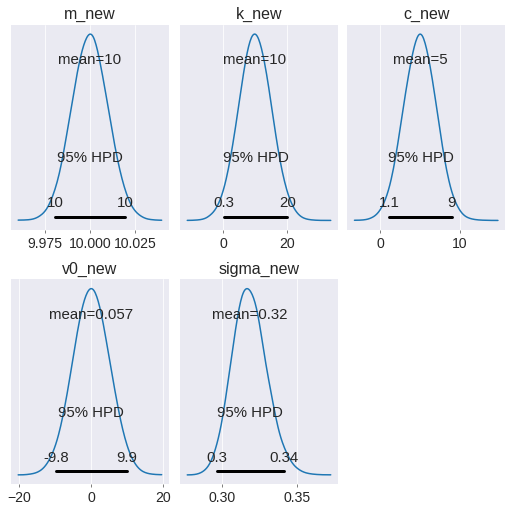

In [11]:
# plot the Posterior densities
_=pm.plots.plot_posterior(trace, figsize=(7,7),credible_interval=0.95)

## Plot the posterior covariance between the system parameters

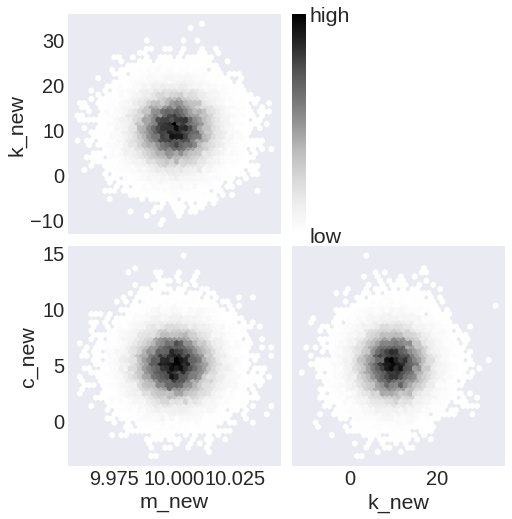

In [12]:
# Your Code Here
_=pm.plots.pairplot(trace,figsize=(7,7),var_names=['m_new','k_new','c_new'],kind='hexbin',colorbar=True)


# Task 3: Uncertain mass

Above, we assumed that we had a fairly good prior idea of the mass of the system. What if we were less sure and wanted to try to infer the mass as well?

To see how this would turn out, re-run your original model from above, except this time make the prior belief about the mass less certain -- perhaps you are not sure exactly how much the mass might weigh.... That is, instead of making your prior distribution on the mass $P(m) \sim  {\cal N}(\mu_m=10, \sigma_m = 0.01)$, *instead* increase the standard deviation to $\sigma_m = 3$ -- a significant increase in prior uncertainty (e.g., the mass could now range anywhere from around 1-ish to 20-ish.

Re-Run your probabilistic program from above, and include some of the same outputs such as (1) the trace plot, (2) the summary statistics of the parameters, and (3) the posterior covariance between m, c, and k. Note any changes. Likewise, re-plot the predicted displacement vs t as you did above (including the upper and lower bounds). Note any changes.

Warning: Convergence on these sampling steps may be signficantly slower than what you saw for Task 2, so budget waiting time accordingly.


In [0]:
# Instantiate probabilistic variable
with pm.Model() as new_model:
  m_new = pm.Normal('m_new', mu=10 , sd=3)
  k_new = pm.Normal('k_new', mu=10 , sd=5)
  c_new = pm.Normal('c_new', mu=5 , sd=2)
  v0_new = pm.Normal('v0_new', mu=0 , sd=5)
  sigma_new = pm.Gamma('sigma_new', alpha=0.2 , beta=1 )
  y0 = 1

  # ynew = MSD(time_vec, m_new, k_new, c_new, y0, v0_new)

  # Probabilistic Model
  # Y_prb = pm.Normal('Y_prb', mu = ytrue , sd = sigma_new**2 , observed = measurements)
  Y_prb = sum([pm.Normal('Y_prb', mu = ytrue , sd = sigma_new**2 , observed = measurements)*m_new*k_new*c_new*v0_new*sigma_new],T )

In [14]:
# Sampling Code Here
# Sampling Code
with new_model:
    trace_new = pm.sample(15000 , tune = 2000 , chains = 3 , target_accept = 0.99, progressbar = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [sigma_new, v0_new, c_new, k_new, m_new]
100%|██████████| 17000/17000 [00:31<00:00, 539.23it/s]


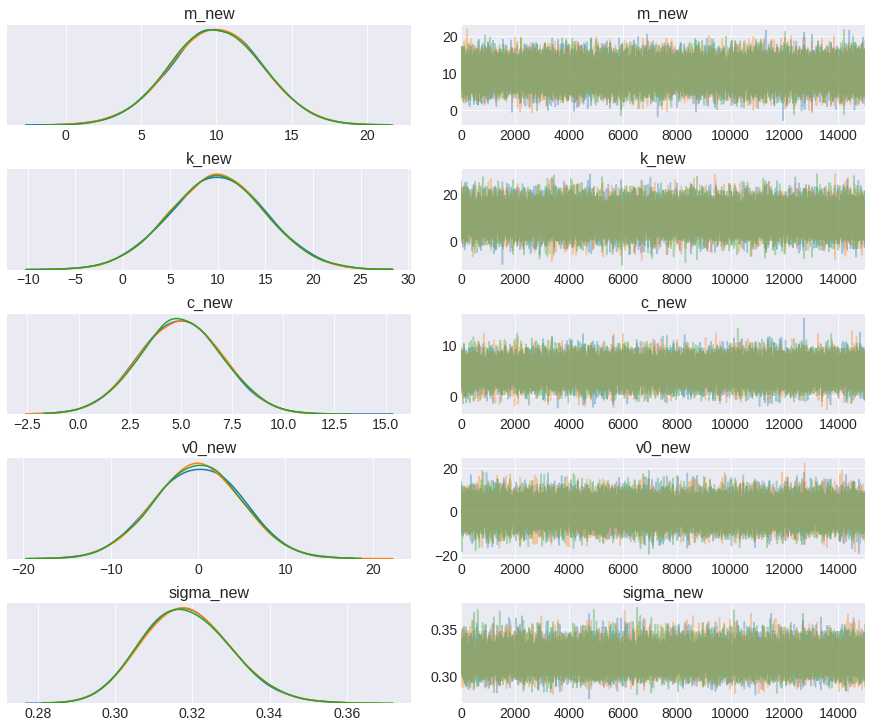

In [15]:
# Your Visualization/Inspect code here
# Your Code here
_ = pm.traceplot(trace_new)

In [16]:
# Summary Statistics of the unknown parameters
# pm.summary(trace)
# Mean and 95% posterior interval of the unknown parameters
def trace_quantiles_UB(x):
   return pd.DataFrame(pm.quantiles(x, [95]))

def trace_quantiles_LB(x):
   return pd.DataFrame(pm.quantiles(x, [-95]))

  
def trace_mean(x):
  return pd.Series(np.mean(x,0) , name = 'mean')

print(pm.summary(trace_new, ['m_new'], stat_funcs=[trace_mean,trace_quantiles_UB, trace_quantiles_LB]))
print(pm.summary(trace_new, ['k_new'], stat_funcs=[trace_mean,trace_quantiles_UB, trace_quantiles_LB]))
print(pm.summary(trace_new, ['c_new'], stat_funcs=[trace_mean,trace_quantiles_UB,trace_quantiles_LB]))

           mean         95       -95
m_new  9.995459  14.931813  5.057649
           mean         95       -95
k_new  9.978154  18.215107  1.756424
           mean        95       -95
c_new  4.992976  8.277297  1.717418


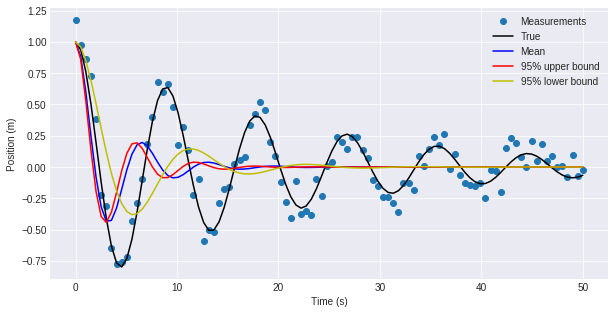

In [22]:
ymean_new = MSD(time_vec, m=9.98, k=9.96, c=4.99, y0=1, v0=0)

y95_ub_new = MSD(time_vec, m=14.96, k=18.25, c=8.25, y0=1, v0=0)

y95_lb_new = MSD(time_vec, m=5.01, k=1.68, c=1.70, y0=1, v0=0)

plt.figure(figsize=(10, 5))
plt.plot(time_vec, measurements,'o', label='Measurements')
plt.plot(time_vec, ytrue, 'k', label = 'True')
plt.plot(time_vec, ymean_new, 'b', label='Mean')
plt.plot(time_vec, y95_ub_new, 'r', label='95% upper bound')
plt.plot(time_vec, y95_lb_new, 'y', label ='95% lower bound')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()


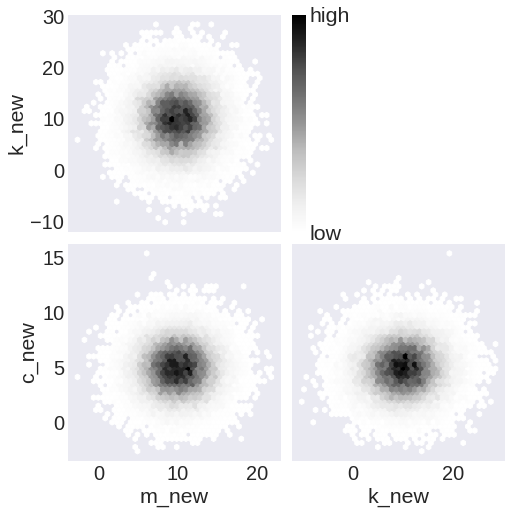

In [18]:
_=pm.plots.pairplot(trace_new,figsize=(7,7),var_names=['m_new','k_new','c_new'],kind='hexbin',colorbar=True)

Hint: To help understand the above, see the below code where we plot the behavior of four different (deterministic) systems:

1. m = 10, k = 5, c = 1
2. m = 20, k = 10, c = 2
3. m = 30, k = 15, c = 3
4. m = 30, k = 20, c = 3

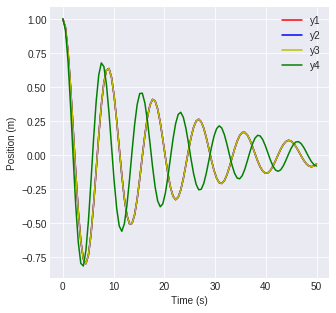

In [20]:
# Plot a few example systems with different masses, spring constants, and damping
y1 = MSD(time_vec, 
           m=10, k=5, c=1, y0=1, v0=0)
y2 = MSD(time_vec, 
           m=20, k=10, c=2, y0=1, v0=0)
y3 = MSD(time_vec, 
           m=30, k=15, c=3, y0=1, v0=0)

y4 = MSD(time_vec, 
           m=30, k=20, c=3, y0=1, v0=0)

## y3, y1 and y2 are overlapping,
## if the ratio is same, then it overalaps
plt.figure(figsize=(5, 5))
plt.plot(time_vec, y1,'r', label='y1')
plt.plot(time_vec, y2, 'b', label='y2')
plt.plot(time_vec, y3, 'y', label='y3')
plt.plot(time_vec, y4, 'g', label='y4')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()